# Library loading

In [1]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib, torch, time, h5py
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

from sklearn.metrics import mean_squared_error

import neuravi

import viscopy as vp

device = torch.device('cpu') #get_default_device()
print(device)

import mpltern
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

cpu


# Load dataset

In [2]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"
path_liquidus = "./data/NKAS_liquidus.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,path_liquidus,device)


# Function to bag models

This object will help bagging results from 10 models and calling their predictions.

In [3]:
class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_n")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg', 'tvf')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

# Loading the models

In [4]:
path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

# Test figure

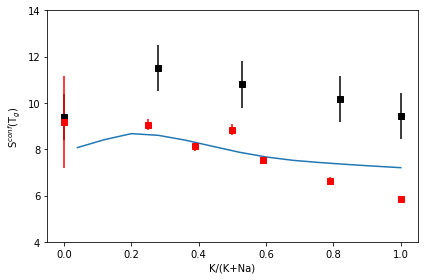

In [5]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$), J mol$^{-1}$ K$^{-1}$")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.005)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),'r-',label="NN model tectosilicates")

## endmember silicate
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),'k-',label="NN model trisilicates")


plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")
plt.legend()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1)

plt.plot(x_raman_shift,raman_valid_predictions[0,:],color="C1",label="Model")
plt.plot(x_raman_shift,ds.y_raman_valid[0,:].detach().numpy(),"k-",label="Data")


plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")

plt.legend(loc="best")

plt.subplot(2,2,2)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("tg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Glass transition temperature T$_{g}$, K$^{-1}$")

plt.subplot(2,2,3)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
plt.ylim(4,16)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")

plt.subplot(2,2,4)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("fragility",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
#plt.ylim(18,47)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Melt fragility $m$")

#plt.ylim(5,14)

plt.tight_layout()
plt.savefig("./figures/Pres_FigRaman.pdf")

# Errors on viscosity

In [6]:
criterion = torch.nn.MSELoss()

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

ag_after_train = np.sqrt(mean_squared_error(y_ag_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
ag_after_valid = np.sqrt(mean_squared_error(y_ag_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
ag_after_test = np.sqrt(mean_squared_error(y_ag_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('AG train loss after training {0:.2f}'.format(ag_after_train))
print('AG valid loss after training {0:.2f}'.format(ag_after_valid))
print('AG test loss after training {0:.2f}'.format(ag_after_test))
print('')

tvf_after_train = np.sqrt(mean_squared_error(y_tvf_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
tvf_after_valid = np.sqrt(mean_squared_error(y_tvf_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
tvf_after_test  = np.sqrt(mean_squared_error(y_tvf_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('TVF train loss after training {0:.2f}'.format(tvf_after_train))
print('TVF valid loss after training {0:.2f}'.format(tvf_after_valid))
print('TVF test loss after training {0:.2f}'.format(tvf_after_test))
print('')

myega_after_train = np.sqrt(mean_squared_error(y_myega_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
myega_after_valid = np.sqrt(mean_squared_error(y_myega_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
myega_after_test = np.sqrt(mean_squared_error(y_myega_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('myega train loss after training {0:.2f}'.format(myega_after_train))
print('myega valid loss after training {0:.2f}'.format(myega_after_valid))
print('myega test loss after training {0:.2f}'.format(myega_after_test))
print('')

am_after_train = np.sqrt(mean_squared_error(y_am_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
am_after_valid = np.sqrt(mean_squared_error(y_am_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
am_after_test = np.sqrt(mean_squared_error(y_am_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('am train loss after training {0:.2f}'.format(am_after_train))
print('am valid loss after training {0:.2f}'.format(am_after_valid))
print('am test loss after training {0:.2f}'.format(am_after_test))
print('')

cg_after_train = np.sqrt(mean_squared_error(y_cg_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
cg_after_valid = np.sqrt(mean_squared_error(y_cg_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
cg_after_test = np.sqrt(mean_squared_error(y_cg_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('cg train loss after training {0:.2f}'.format(cg_after_train))
print('cg valid loss after training {0:.2f}'.format(cg_after_valid))
print('cg test loss after training {0:.2f}'.format(cg_after_test))
print('')

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('density train loss after training {0:.3f}'.format(ese_density_train))
print('density valid loss after training {0:.3f}'.format(ese_density_valid))
print('density test loss after training {0:.3f}'.format(ese_density_test))
print('')

print('refractive index train loss after training {0:.3f}'.format(ese_ri_train))
print('refractive index valid loss after training {0:.3f}'.format(ese_ri_valid))
print('refractive index test loss after training {0:.3f}'.format(ese_ri_test))
print('')


AG train loss after training 0.33
AG valid loss after training 0.22
AG test loss after training 0.35

TVF train loss after training 0.36
TVF valid loss after training 0.23
TVF test loss after training 0.36

myega train loss after training 0.36
myega valid loss after training 0.25
myega test loss after training 0.35

am train loss after training 0.34
am valid loss after training 0.24
am test loss after training 0.34

cg train loss after training 0.40
cg valid loss after training 0.23
cg test loss after training 0.34

density train loss after training 0.069
density valid loss after training 0.078
density test loss after training 0.081

refractive index train loss after training 0.003
refractive index valid loss after training 0.003
refractive index test loss after training 0.005



# Compare with Giordano

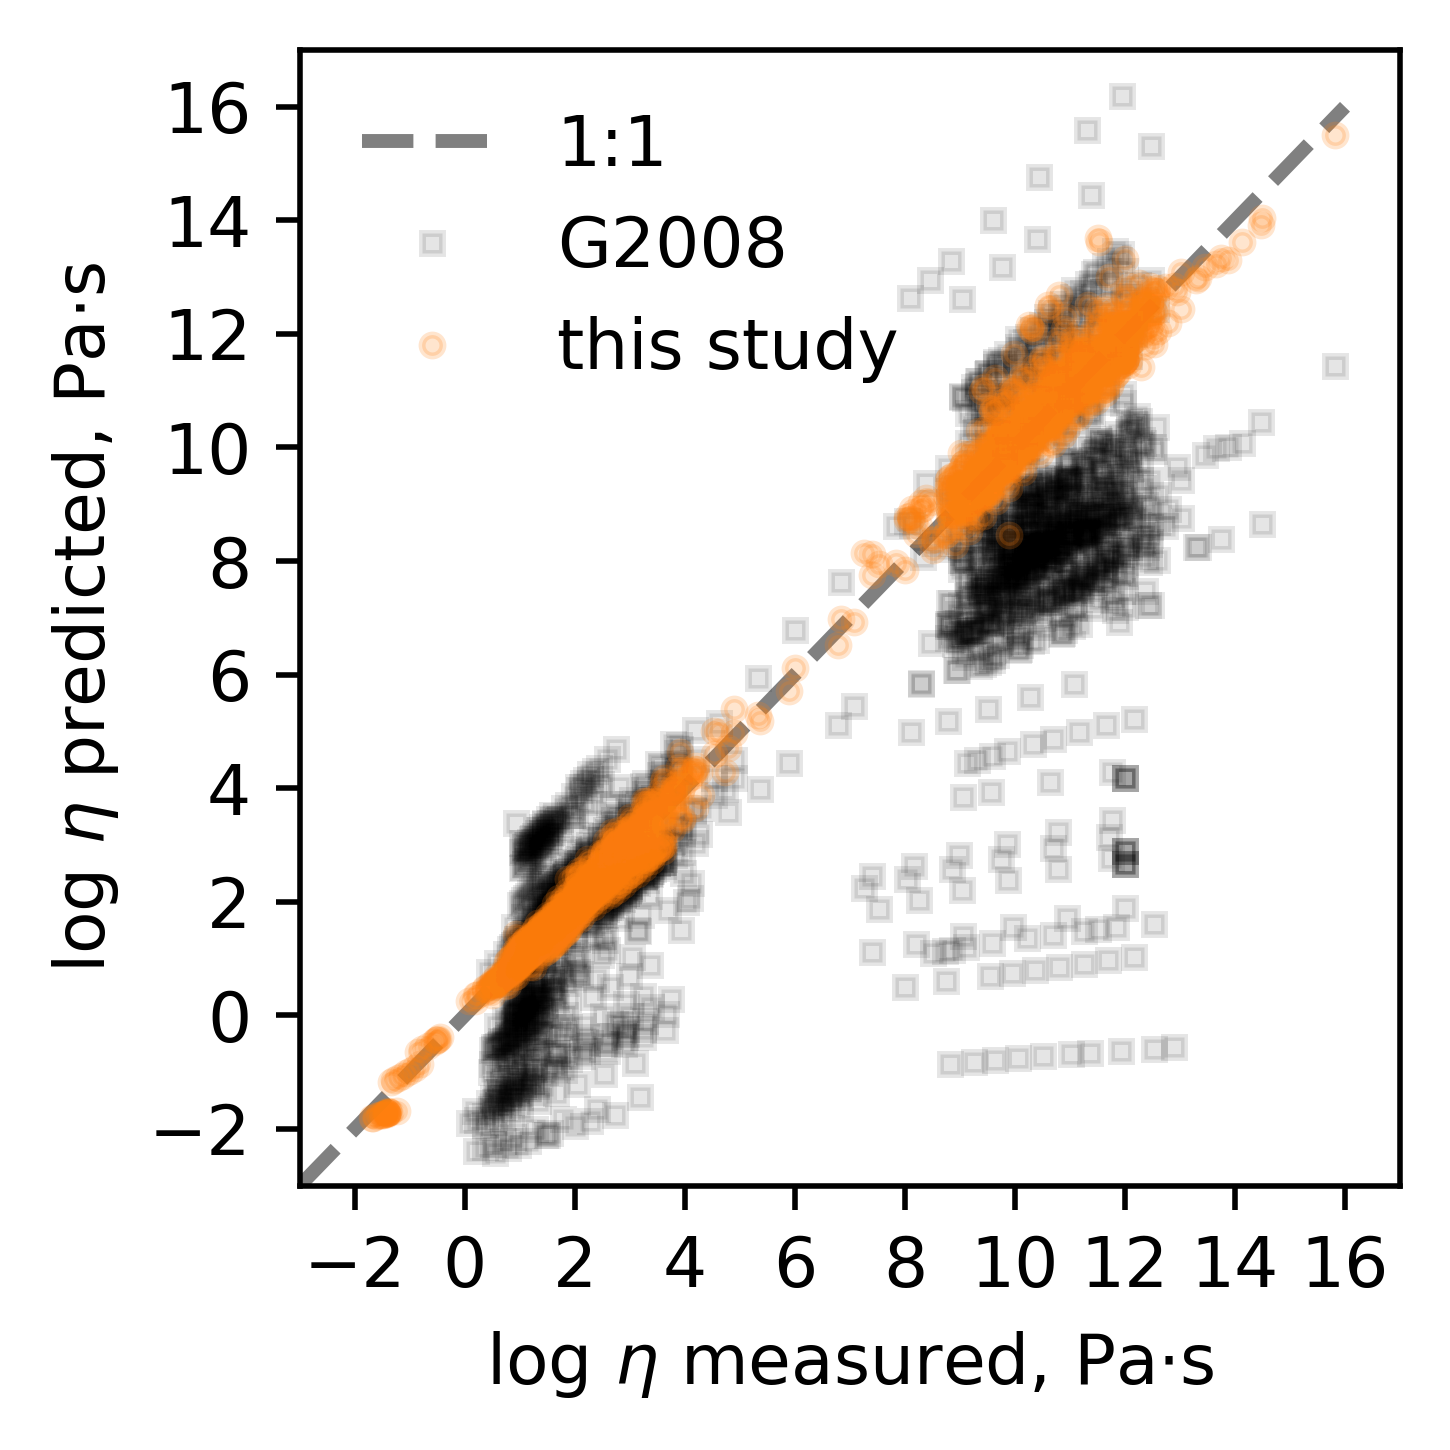

In [7]:
datas_ = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
datas_ = vp.chimie_control(datas_)
Gmodel = vp.G2008(datas_)

plt.figure(figsize=(3.,3.),dpi=500)

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.plot(datas_.viscosity,Gmodel[0],"ks",markersize=3,alpha=0.1,label="G2008")

plt.xticks([-2,0,2,4,6,8,10,12,14,16])
plt.yticks([-2,0,2,4,6,8,10,12,14,16])

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.ylabel("log $\eta$ predicted, Pa$\cdot$s")
plt.xlabel("log $\eta$ measured, Pa$\cdot$s")

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("./figures/Comp_G2008.png")

plt.plot(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.mean(axis=1),"o",color="C1",markersize=3,alpha=0.2,label="this study")
plt.plot(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.mean(axis=1),"o",color="C1",markersize=3,alpha=0.2)
plt.plot(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.mean(axis=1),"o",color="C1",markersize=3,alpha=0.2)
plt.legend(frameon=False)
plt.savefig("./figures/Comp_G2008_LL.png")


# For presentation

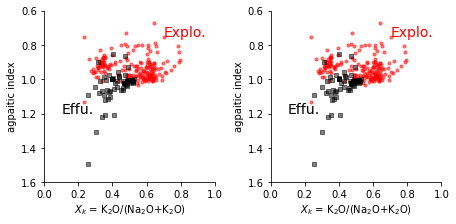

In [8]:
#
# our real x axis, for resampling
#

x_raman_shift = np.arange(400.,1250.,1.0)
# Loading the data from Di Genova 2017
dataset_DG2017 = pd.read_excel("./data/dev/nature24488-s2-modified.xlsx")
dataset_DG2017.head()

dataset_DG2017 = dataset_DG2017.groupby('Location').mean().reset_index()

nb_samples = 20000

X_rh = pd.DataFrame()
X_rh["sio2"] = np.random.random_sample(nb_samples)*0.04 + 0.78

R_MAl = np.random.random_sample(nb_samples)*0.4 + 0.3 # ratio of alkalis to Al
R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

X_rh["al2o3"] = (1.0 - R_MAl)*(1-X_rh["sio2"])
X_rh["na2o"] = (1-X_rh["sio2"]-X_rh["al2o3"])*(1-R_XK)
X_rh["k2o"] = (1-X_rh["sio2"]-X_rh["al2o3"]-X_rh["na2o"])

rh_sctg = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)
rh_be = neuralmodel.predict("be",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

Raman_rh = neuralmodel.predict("raman_pred",X_rh.values).mean(axis=2)

Rr_rh = np.trapz(Raman_rh[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_rh[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

plotted_structure = Rr_rh.reshape(-1)
plotted_entropy = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

plt.figure(figsize=(6.44,3.22))

ax1 = plt.subplot(1,2,1)

ax1.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
ax1.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

ax1.annotate("Effu.", xy=(0.1,1.2),xycoords="data",color="black",fontsize=14)
ax1.annotate("Explo.", xy=(0.7,0.75),xycoords="data",color="red",fontsize=14)

ax1.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax1.set_ylabel(r"agpaitic index")
ax1.set_xlim(0,1)
ax1.set_ylim(1.6,0.6)

# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = plt.subplot(1,2,2)

ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

ax2.annotate("Effu.", xy=(0.1,1.2),xycoords="data",color="black",fontsize=14)
ax2.annotate("Explo.", xy=(0.7,0.75),xycoords="data",color="red",fontsize=14)

ax2.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax2.set_ylabel(r"agpaitic index")
ax2.set_xlim(0,1)
ax2.set_ylim(1.6,0.6)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/agpaitic.pdf')




In [9]:
#
# our real x axis, for resampling
#

x_raman_shift = np.arange(400.,1250.,1.0)
# Loading the data from Di Genova 2017
dataset_DG2017 = pd.read_excel("./data/dev/nature24488-s2-modified.xlsx")
dataset_DG2017.head()

dataset_DG2017 = dataset_DG2017.groupby('Location').mean().reset_index()

nb_samples = 20000

X_rh = pd.DataFrame()
X_rh["sio2"] = np.random.random_sample(nb_samples)*0.04 + 0.78

R_MAl = np.random.random_sample(nb_samples)*0.4 + 0.3 # ratio of alkalis to Al
R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

X_rh["al2o3"] = (1.0 - R_MAl)*(1-X_rh["sio2"])
X_rh["na2o"] = (1-X_rh["sio2"]-X_rh["al2o3"])*(1-R_XK)
X_rh["k2o"] = (1-X_rh["sio2"]-X_rh["al2o3"]-X_rh["na2o"])

rh_sctg = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)
rh_be = neuralmodel.predict("be",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

Raman_rh = neuralmodel.predict("raman_pred",X_rh.values).mean(axis=2)

Rr_rh = np.trapz(Raman_rh[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_rh[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

#
# WHAT DO WE PLOT?
#

plotted_structure = Rr_rh.reshape(-1)
plotted_entropy = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)


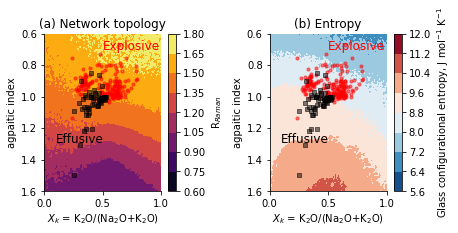

In [39]:
#
# FIGURE
#

fig4, ax = plt.subplots(1,2,figsize=(6.44,3.22))

#
# SUBPLOT 1
#
ax1 = ax[0]

# MODEL
tc1 = ax1.tricontourf(X_rh.loc[:,"k2o"]/(X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"]),
                (X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"])/(X_rh.loc[:,"al2o3"]), 
                plotted_structure.reshape(-1), 
                levels=6, cmap="inferno",antialiased=False)

cbar = fig4.colorbar(tc1, ax=ax1)

cbar.set_label('R$_{Raman}$')

# DATA
ax1.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
ax1.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

ax1.annotate("Effusive", xy=(0.1,0.31),xycoords="axes fraction",color="black",fontsize=12)
ax1.annotate("Explosive", xy=(0.5,0.9),xycoords="axes fraction",color="red",fontsize=12)

ax1.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax1.set_ylabel(r"agpaitic index")
ax1.set_xlim(0,1)
ax1.set_ylim(1.6,0.6)

# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#
# SUBPLOT 2
#
ax2 = ax[1]

# MODEL
tc2 = ax2.tricontourf(X_rh.loc[:,"k2o"]/(X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"]),
                (X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"])/(X_rh.loc[:,"al2o3"]), 
                plotted_entropy.reshape(-1), 
                levels=6, cmap="RdBu_r",antialiased=False)

# Now adding the colorbar
cbar2 = plt.colorbar(mappable=tc2, ax=ax2)
#cbar2 = fig4.colorbar(tc2,ax=ax2,location="top")  


cbar2.set_label('Glass configurational entropy, J mol$^{-1}$ K$^{-1}$')

# DATA
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

ax2.annotate("Effusive", xy=(0.1,0.31),xycoords="axes fraction",color="black",fontsize=12)
ax2.annotate("Explosive", xy=(0.5,0.9),xycoords="axes fraction",color="red",fontsize=12)

ax2.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax2.set_ylabel(r"agpaitic index")
ax2.set_xlim(0,1)
ax2.set_ylim(1.6,0.6)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_title("(a) Network topology")
ax2.set_title("(b) Entropy")

plt.tight_layout()

plt.savefig('./figures/Fig4_agpaitic_entropy.pdf')

# Glass transition

In [11]:
#
# number of samples
#

nb_samples = 10000

#
# Generating the random compositions in the delimited ternary diagram
#

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)#*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
M_glass = sio2_gen*60.08 + al2o3_gen*101.96 + na2o_gen*61.9789 + k2o_gen*94.2
X_rec = X_gen.copy() # this is to have a copy (non-torch, pandas)
X_gen = torch.Tensor(X_gen.values).to(device)

X_rec_forcart = X_rec
X_rec_forcart["alkalis"] = X_rec.na2o+X_rec.k2o
cart_rec = neuravi.bary2cart(X_rec_forcart.loc[:,["alkalis","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# Making predictions
#

Raman_gen = neuralmodel.predict("raman_pred",X_gen).mean(axis=2)

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

# subset of highly correlated parameters

samples_2 = np.concatenate((neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                            Rr_gen.reshape(-1,1)
                           ),axis=1)

labels_2 = [r"$n_{589}$", r"$B_e/S^{conf}(T_g)$", r"$B_{CG}$", r"$T_g$", r"R$_{Raman}$"]


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


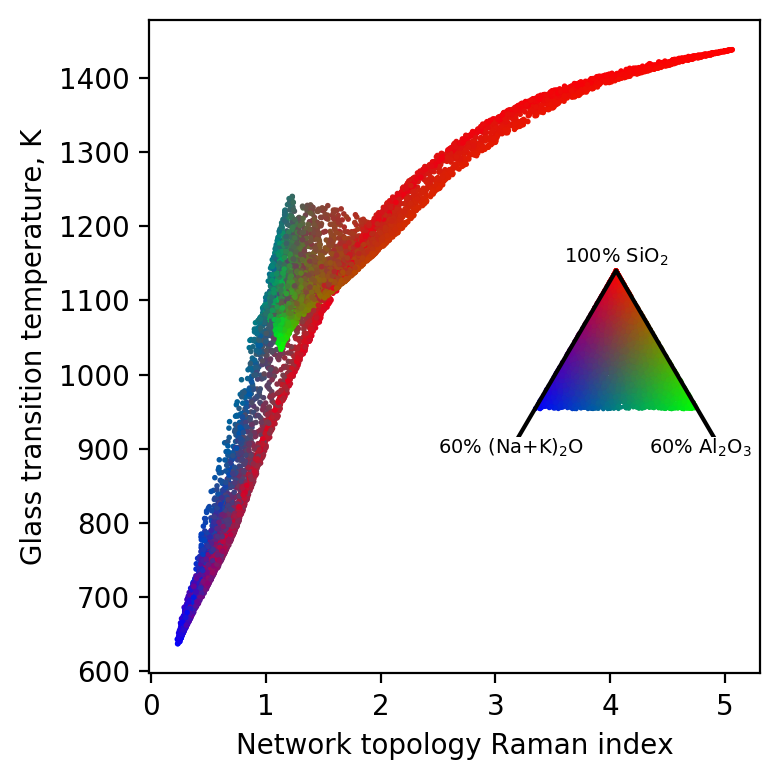

In [21]:
plt.figure(figsize=(4,4),dpi=200)
fig4_a = plt.subplot(1,1,1)

####
#### TERNARY PLOT
####

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(fig4_a, width=1.3, height=0.9,loc='right')

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.5,c=neuravi.CLR(X_gen.detach().numpy()))
axins.plot([0,1,2,0],[0,1,0,0],"k-")

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=7)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=7)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=7)

axins.axis("off")

####
#### DATA PLOT
####

fig4_a.scatter(samples_2[:,4],samples_2[:,3],s=1,c=neuravi.CLR(X_gen.detach().numpy()))

fig4_a.set_ylabel("Glass transition temperature, K")

fig4_a.set_xlabel('Network topology Raman index')

plt.tight_layout()

plt.savefig("./figures/Tg_vs_Rraman.png")